In [180]:
# load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [181]:
# load ratings data
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [182]:
# load movies data
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [183]:
movies.shape

(9742, 3)

In [184]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [185]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [186]:
movies.duplicated().sum()

0

In [187]:
ratings.shape

(100836, 4)

In [188]:
ratings.duplicated().sum()

0

In [189]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [190]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [191]:
# check data
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


In [192]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


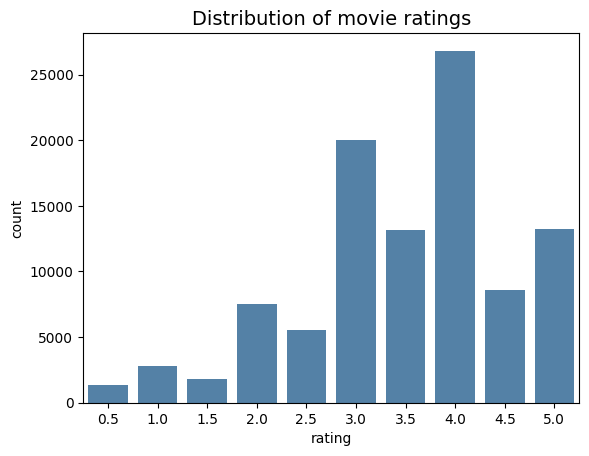

In [193]:
# visual rating distribution
sns.countplot(x="rating", data=ratings, color='steelblue')
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [194]:
# view mean
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [195]:
# count movie rating
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

In [196]:
# count movie min  mean rating
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [197]:
# highest movie rating
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [198]:
# bias movieId  highest rating
ratings[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [199]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean','sum'])
movie_stats.head()

,count,mean,sum
movieId,,,
1,215,3.920930,843.0
2,110,3.431818,377.5
3,52,3.259615,169.5
4,7,2.357143,16.5
5,49,3.071429,150.5


In [200]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [201]:
# movie_rating_1 = pd.Series([5,5,5])
# print("art    mean ",movie_rating_1.mean())
# print("total  rating ",movie_rating_1.sum())
# print("bayes  mean ",bayesian_avg(movie_rating_1))

In [202]:
# movie_rating_2 = pd.Series([4,4,4,4,4,4,4,4,4,4,4,5,5,5])
# print("art   mean ",movie_rating_2.mean())
# print("total  rating ",movie_rating_2.sum())
# print("bayes mean ",bayesian_avg(movie_rating_2))

In [203]:
# movie_rating_3 = pd.Series([4,4,4,5,5,5,5,5,5])
# print("art   mean ",movie_rating_3.mean())
# print("total  rating ",movie_rating_3.sum())
# print("bayes mean ",bayesian_avg(movie_rating_3))

In [204]:
#use bayes avg for fair rating
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [205]:
movie_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9724 entries, 0 to 9723
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       9724 non-null   int64  
 1   count         9724 non-null   int64  
 2   mean          9724 non-null   float64
 3   sum           9724 non-null   float64
 4   bayesian_avg  9724 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 455.8 KB


In [206]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,sum,bayesian_avg,title
1172,1556,19,1.605263,30.5,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,31.5,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,64.5,2.267,Godzilla (1998)
1144,1499,27,1.925926,52.0,2.297,Anaconda (1997)
1988,2643,16,1.687500,27.0,2.307,Superman IV: The Quest for Peace (1987)


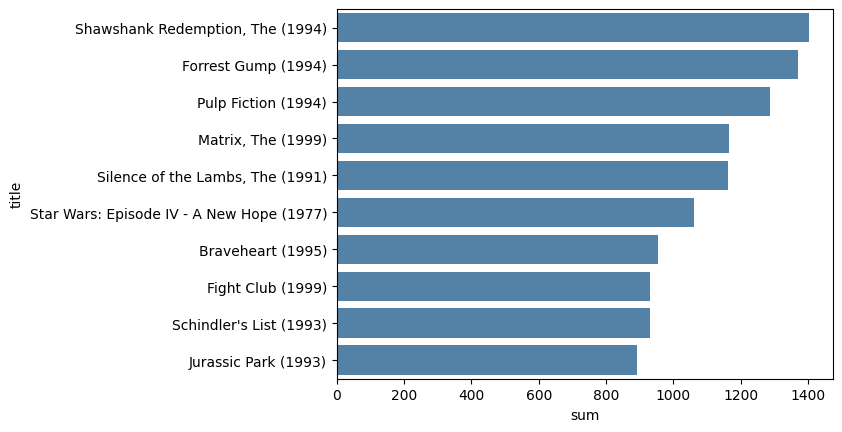

In [207]:
#visual  sum rating
sns.barplot(
              y='title'
              , x='sum'
              , data=movie_stats.sort_values(by='sum', ascending=False )[0:10]
              , color="steelblue"
              )
plt.show()

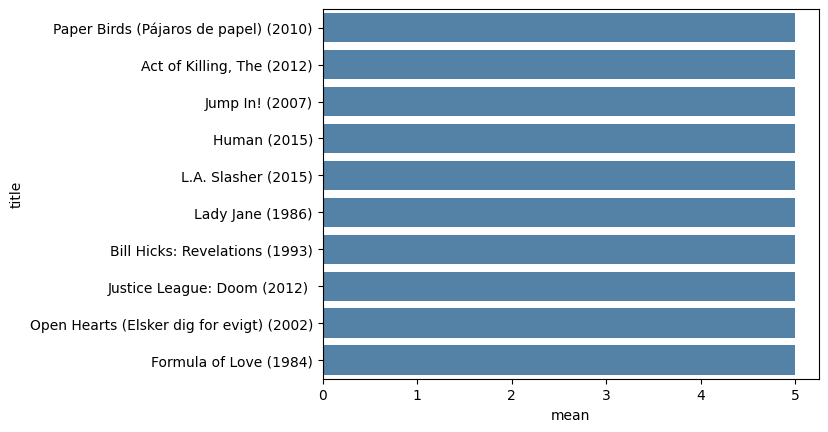

In [208]:
#visual top 10 mean
sns.barplot(
              y='title'
              , x='mean'
              , data=movie_stats.sort_values(by='mean', ascending=False )[0:10]
              , color="steelblue"
              )
plt.show()

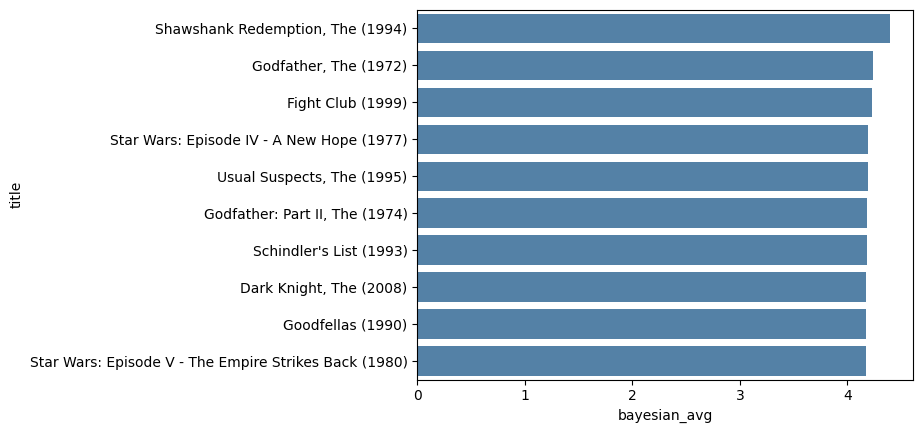

In [209]:
#visual top 10 bayes avg
sns.barplot(
              y='title'
              , x='bayesian_avg'
              , data=movie_stats.sort_values(by='bayesian_avg', ascending=False )[0:10]
              , color="steelblue"
              )
plt.show()

In [210]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,sum,bayesian_avg,title
1172,1556,19,1.605263,30.5,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,31.5,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,64.5,2.267,Godzilla (1998)
1144,1499,27,1.925926,52.0,2.297,Anaconda (1997)
1988,2643,16,1.687500,27.0,2.307,Superman IV: The Quest for Peace (1987)


In [211]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [212]:
rating_plot = ratings[['movieId','rating']].groupby('movieId').agg(['sum','count','mean']).reset_index()
rating_plot.columns = ['_'.join([str(c) for c in lst]) for lst in rating_plot.columns]
rating_plot

,movieId_,rating_sum,rating_count,rating_mean
0,1,843.0,215,3.920930
1,2,377.5,110,3.431818
2,3,169.5,52,3.259615
3,4,16.5,7,2.357143
4,5,150.5,49,3.071429
...,...,...,...,...
9719,193581,4.0,1,4.000000
9720,193583,3.5,1,3.500000
9721,193585,3.5,1,3.500000
9722,193587,3.5,1,3.500000


In [213]:
# counter genre
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [214]:
# top 5 genres
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


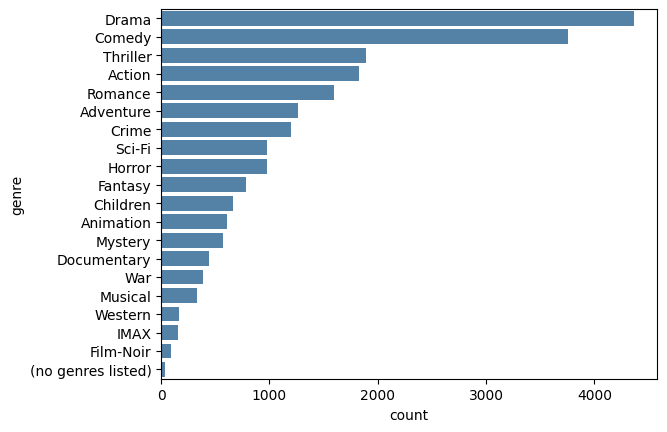

In [215]:
# visual count genres
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(
              y='genre'
              , x='count'
              , data=genre_frequency_df.sort_values(by='count', ascending=False )
              , color="steelblue"
              )
plt.show()

In [216]:
# create  user rating utility matrix
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userId'].nunique()
    N = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

# X is matrix user row  item column
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [217]:
#movie_inv_mapper


In [218]:
def plot_matrix_sparse(matrix):
  plt.figure(figsize=(8, 5))
  plt.imshow(matrix, cmap='Blues', interpolation='none', aspect='auto')
  plt.colorbar()
  plt.title('Sparse Matrix Plot')
  plt.xlabel('Column')
  plt.ylabel('Row')
  plt.show()



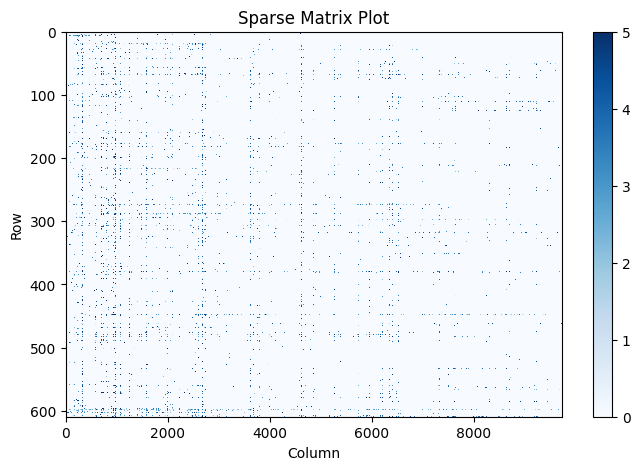

In [219]:
plot_matrix_sparse(X.toarray())

In [220]:
# check sparsity
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [221]:
# check rating per user
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [222]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [223]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [224]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


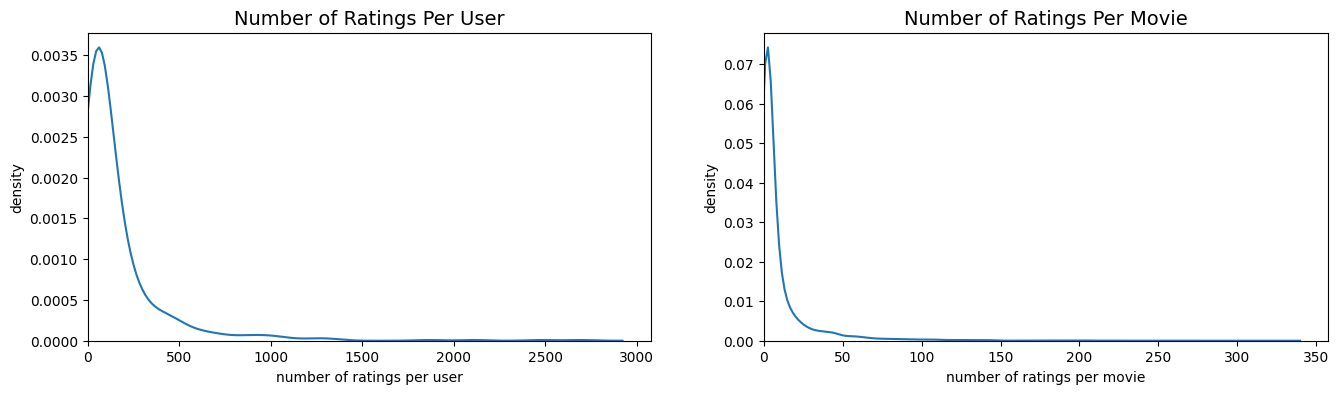

In [225]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("number of ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("number of ratings per movie")
plt.ylabel("density")
plt.show()

In [226]:
#calculate knn
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    # input ( ุ610,9724)
    # ( ุ9724,610)
    X = X.T
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

def find_similar_user():
  pass

In [227]:
# create

#user_id to  matrix index
print(user_mapper[1])

#matrix index to user_id
print(user_inv_mapper[0])

0
1


In [228]:
# function find similar user
def find_similar_user(userid,similarity_threshold,number_similar):
  # similarity score
  user_cosine_sim  = cosine_similarity(X,X)

  #output
  similar_user_list = []

  #convert id to index
  user_index  =  user_mapper[userid]

  df_users_sim  = pd.DataFrame(user_cosine_sim)
  df_users_sim.reset_index()
  df_user_sim = df_users_sim.iloc[user_index,:].reset_index()
  df_user_sim.columns = ['user_index', 'similarity']

  # drop owner id row
  df_user_sim.drop(index=user_index, inplace=True)

  #get simirlarity score by threshold
  df_top_similar = df_user_sim[df_user_sim['similarity']> similarity_threshold]

  #sort value
  df_top_similar = df_top_similar.sort_values(by="similarity",ascending=False)[:number_similar]

  for index, row in df_top_similar.iterrows():
    #user_inv_mapper
    user_index  = row['user_index']
    user_id  =  user_inv_mapper[user_index]
    similarity = row['similarity']
    print(f"user_index {user_index} user_id {user_id} similarity {similarity}")
    similar_user_list.append(user_id)

  return similar_user_list



In [229]:
df_ratings  = ratings.copy()
def find_movie_by_similar_user(user_id,user_similar_list,number_similar):

  #user have watch
  user_watch_movie_id = df_ratings[df_ratings['userId']==user_id]['movieId'].unique().tolist()
  #print(user_watch_movie_id)

  # filter movie from similar user
  df_user_sim_rating  = df_ratings[df_ratings['userId'].isin(user_similar_list)]

  #filter movie user have watch out
  df_user_sim_rating = df_user_sim_rating[~df_user_sim_rating['movieId'].isin(user_watch_movie_id)]

  # calculate bayesian average
  sim_bayesian_avg_ratings = df_user_sim_rating.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
  sim_bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
  sim_bayesian_avg_ratings = sim_bayesian_avg_ratings.sort_values('bayesian_avg',ascending=False)
  return sim_bayesian_avg_ratings[0:number_similar]

In [230]:
# user based collaborative
user_id  = 111
similarity_threshold = 0.3
number_similar = 10

print("="*100)
print("User based collaborative for user id ",user_id)
print("="*100)

#find similarity user
similar_user_list = find_similar_user(user_id,similarity_threshold,number_similar)
print("user similarity ",similar_user_list)

#find bayes avg movie from similar user
sim_bayesian_avg_ratings = find_movie_by_similar_user(user_id,similar_user_list,number_similar)

movie_titles = dict(zip(movies['movieId'], movies['title']))
for index, row in sim_bayesian_avg_ratings.iterrows():
    movie_name  = movie_titles[row['movieId']]
    bayes_avg = row['bayesian_avg']
    print(f"{movie_name} bayes avg score {bayes_avg}")

User based collaborative for user id  111
user_index 364.0 user_id 365 similarity 0.36572242484307393
user_index 248.0 user_id 249 similarity 0.3623579652506525
user_index 563.0 user_id 564 similarity 0.33163819836344577
user_index 67.0 user_id 68 similarity 0.3240199897319789
user_index 297.0 user_id 298 similarity 0.30917604221614087
user_index 231.0 user_id 232 similarity 0.3083988975503424
user similarity  [365, 249, 564, 68, 298, 232]
Star Wars: Episode VI - Return of the Jedi (1983) bayes avg score 3.677
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) bayes avg score 3.677
Star Wars: Episode V - The Empire Strikes Back (1980) bayes avg score 3.665
Sin City (2005) bayes avg score 3.607
Star Wars: Episode IV - A New Hope (1977) bayes avg score 3.6
Godfather, The (1972) bayes avg score 3.572
Seven (a.k.a. Se7en) (1995) bayes avg score 3.572
Saving Private Ryan (1998) bayes avg score 3.54
Indiana Jones and the Last Crusade (1989) bayes avg score 3.537
S

In [231]:
#item based
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [232]:
#item based
movie_id = 10
similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched GoldenEye (1995):
Die Hard: With a Vengeance (1995)
True Lies (1994)
Clear and Present Danger (1994)
Speed (1994)
Batman (1989)
Stargate (1994)
Jurassic Park (1993)
Batman Forever (1995)
Mission: Impossible (1996)


In [233]:
len(movie_titles)

9742

In [234]:
movie_id = 10

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched GoldenEye (1995):
Cliffhanger (1993)
Batman Forever (1995)
Judge Dredd (1995)
Clear and Present Danger (1994)
Mortal Kombat (1995)
Tomorrow Never Dies (1997)
Demolition Man (1993)
Die Hard: With a Vengeance (1995)
Beverly Hills Cop III (1994)


In [235]:

n_movies = movies['movieId'].nunique()
print(f"There are {n_movies} unique movies in our movies dataset.")

There are 9742 unique movies in our movies dataset.


In [236]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [237]:
movies_temp = movies.copy()
movies_temp.genres.transform

<bound method Series.transform of 0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object>

In [238]:
# genres = {'Documentary', 'Thriller', 'Children', 'Crime', 'War', 'Action', '(no genres listed)', 'Fantasy', 'Drama', 'Film-Noir', 'Comedy', 'Adventure', 'Romance', 'Horror', 'Western', 'IMAX', 'Sci-Fi', 'Musical', 'Mystery', 'Animation'}

# movies_temp['Film-Noir']= movies_temp.genres.transform(lambda x: int(g in x))


# movies_temp['Film-Noir']

# # for g in genres:
# #     print(g)



In [239]:

genres = set(g for G in movies['genres'] for g in G)
for g in genres:
    # print(g)
    # print(int(g))
    movies[g] = movies.genres.transform(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [240]:
from sklearn.metrics.pairwise import cosine_similarity

# create movie_genres cosine matrix for content based
cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [241]:
def plot_heatmap_cosine(sparse_matrix):
  plt.imshow(sparse_matrix, cmap='Blues', vmin=0, vmax=1)
  plt.colorbar(label='Cosine Similarity')
  plt.title('Movie Genres Cosine Similarity Matrix Heatmap')
  plt.show()


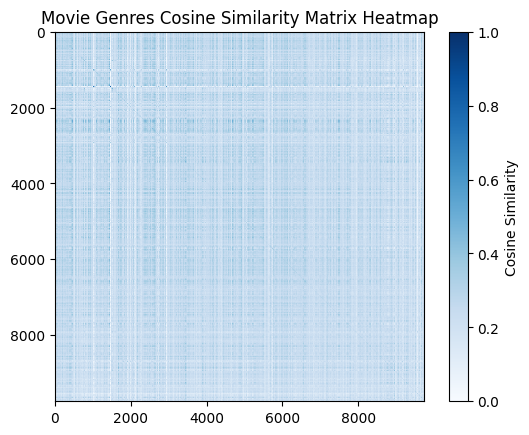

In [242]:
plot_heatmap_cosine(cosine_sim)

In [243]:
pip install fuzzywuzzy

In [244]:

from fuzzywuzzy import process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

In [245]:
title = movie_finder('speed')
title

'Speed (1994)'

In [246]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Jumanji: {idx}")

Movie index for Jumanji: 334


In [247]:
n_recommendations=10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]

In [248]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Speed (1994):


1173      Speed 2: Cruise Control (1997)
594                       Twister (1996)
948     Femme Nikita, La (Nikita) (1990)
1131                   Saint, The (1997)
1398                   Armageddon (1998)
1856           Jumpin' Jack Flash (1986)
2108              Tequila Sunrise (1988)
2408                Presidio, The (1988)
2583               Romeo Must Die (2000)
2677                   Breathless (1983)
Name: title, dtype: object

In [249]:
# content base function
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    print(idx)
    sim_scores = list(enumerate(cosine_sim[idx]))

    #print(sim_scores)


    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]

    similar_movies = [i[0] for i in sim_scores]
    similar_point = [i[1] for i in sim_scores]
    similar_movies_title = movies['title'].iloc[similar_movies].to_list()


    # dictionary of lists
    dict_cosine = {
                      'movie_id': similar_movies
                      ,'movie_title':similar_movies_title
                      ,'cosine_similarity': similar_point }

    df_cosine_score  = pd.DataFrame(dict_cosine)

    #print(type(df_cosine_score))

    print(f"Because you watched {title}:")
    for i in range(len(df_cosine_score)):
      movie_tile = df_cosine_score.loc[i, "movie_title"]
      consine_similarity = df_cosine_score.loc[i, "cosine_similarity"]
      print(f"{movie_tile} ==> [cosine similarity score {consine_similarity}]")
    #print(type(df_cosine_score['cosine_similarity'].loc(similar_movies)))

In [250]:
get_content_based_recommendations("star war",10)

224
Because you watched Star Wars: Episode IV - A New Hope (1977):
Star Wars: Episode IV - A New Hope (1977) ==> [cosine similarity score 1.0000000000000002]
Stargate (1994) ==> [cosine similarity score 1.0000000000000002]
Demolition Man (1993) ==> [cosine similarity score 1.0000000000000002]
Star Wars: Episode V - The Empire Strikes Back (1980) ==> [cosine similarity score 1.0000000000000002]
Star Wars: Episode VI - Return of the Jedi (1983) ==> [cosine similarity score 1.0000000000000002]
Star Trek III: The Search for Spock (1984) ==> [cosine similarity score 1.0000000000000002]
Lost in Space (1998) ==> [cosine similarity score 1.0000000000000002]
Rocketeer, The (1991) ==> [cosine similarity score 1.0000000000000002]
Tron (1982) ==> [cosine similarity score 1.0000000000000002]
Six-String Samurai (1998) ==> [cosine similarity score 1.0000000000000002]


In [251]:
get_content_based_recommendations('toy story', 10)

0
Because you watched Toy Story (1995):
Antz (1998) ==> [cosine similarity score 0.9999999999999999]
Toy Story 2 (1999) ==> [cosine similarity score 0.9999999999999999]
Adventures of Rocky and Bullwinkle, The (2000) ==> [cosine similarity score 0.9999999999999999]
Emperor's New Groove, The (2000) ==> [cosine similarity score 0.9999999999999999]
Monsters, Inc. (2001) ==> [cosine similarity score 0.9999999999999999]
Wild, The (2006) ==> [cosine similarity score 0.9999999999999999]
Shrek the Third (2007) ==> [cosine similarity score 0.9999999999999999]
Tale of Despereaux, The (2008) ==> [cosine similarity score 0.9999999999999999]
Asterix and the Vikings (Astérix et les Vikings) (2006) ==> [cosine similarity score 0.9999999999999999]
Turbo (2013) ==> [cosine similarity score 0.9999999999999999]


In [252]:
X.shape

(610, 9724)

In [253]:
from sklearn.decomposition import TruncatedSVD

def get_factorized_matrix(original_matrix,n_component):
  svd = TruncatedSVD(n_components=n_component, n_iter=10)
  factorized_matrix = svd.fit_transform(X.T)
  return factorized_matrix , svd

In [254]:
# how to find best n_components for factorize
n_components_random = 600
factorized_matrix , svd  = get_factorized_matrix(X,n_components_random)

cumu_sum  = np.cumsum(svd.explained_variance_ratio_)
min_n_conponent = np.argwhere(cumu_sum>=0.99)[0]
min_n_conponent[0] +=1

factorized_matrix , svd  = get_factorized_matrix(X,min_n_conponent[0])



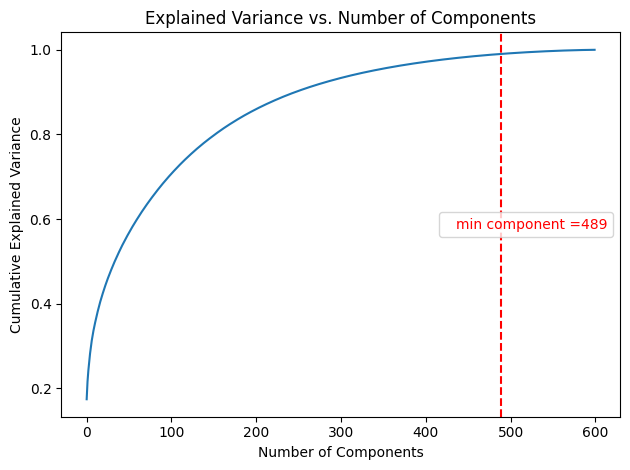

In [255]:
# Plot explained variance ratio
plt.plot(cumu_sum)
plt.axvline(x=min_n_conponent[0], color='r', label=min_n_conponent[0], ls='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.legend(labels=["min component ="+str(min_n_conponent[0])],labelcolor="r",handlelength=0,loc="center right")


plt.tight_layout()
plt.show()

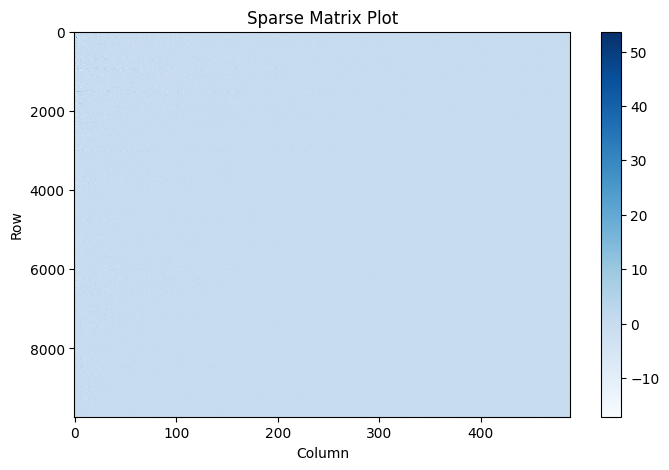

In [256]:
plot_matrix_sparse(factorized_matrix)


In [257]:
# import numpy as np
# from sklearn.decomposition import TruncatedSVD
# from scipy.linalg import svd

# # Create a sample matrix
# X = np.array([[1, 2, 3],
#               [4, 5, 6],
#               [7, 8, 9]])

# svd = TruncatedSVD(2)
# X_transformed = svd.fit_transform(X)

# U = X_transformed / svd.singular_values_
# Sigma_matrix = np.diag(svd.singular_values_)
# VT = svd.components_

# VT.shape

# # recounstruce = np.matmul(np.matmul(U,Sigma_matrix),VT)
# # recounstruce

In [258]:
movie_id = 1
#factorized_matrix.T  back to user row movie column
similar_movies = find_similar_movies(movie_id, factorized_matrix.T, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


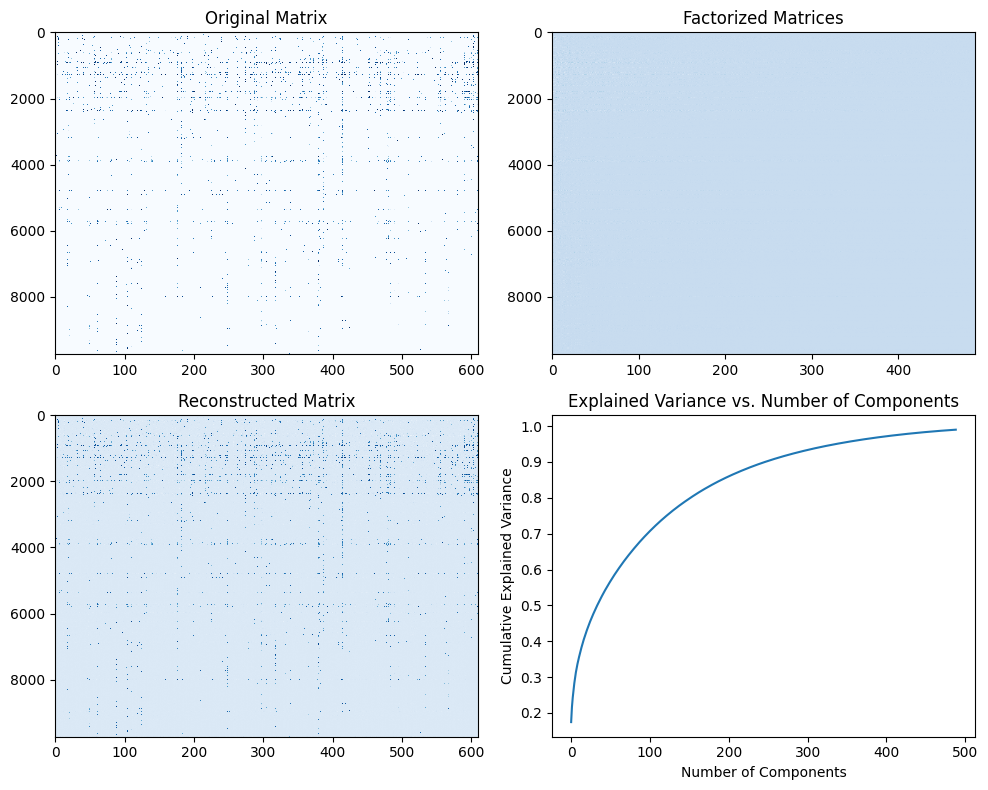

In [259]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_spd_matrix


reconstructed_matrix = svd.inverse_transform(factorized_matrix)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Original Matrix
axs[0, 0].imshow(X.T.toarray(), cmap='Blues', interpolation='none', aspect='auto')
axs[0, 0].set_title('Original Matrix')

# Factorized Matrices
axs[0, 1].imshow(factorized_matrix, cmap='Blues', interpolation='none', aspect='auto')
axs[0, 1].set_title('Factorized Matrices')

# Reconstructed Matrix
axs[1, 0].imshow(reconstructed_matrix, cmap='Blues', interpolation='none', aspect='auto')
axs[1, 0].set_title('Reconstructed Matrix')

# Singular Values

# Plot explained variance ratio
axs[1, 1].plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')

plt.tight_layout()
plt.show()


In [260]:
cumu_sum  = np.cumsum(svd.explained_variance_ratio_)
cumu_sum.argmax()

# conponetns = np.where(cumu_sum >=0.99)

# conponetns[]

cumu_sum[cumu_sum.argmax()]


0.9899933855329595

In [261]:
def precision_at_k(actual, predicted, k):
    # Get the top-k predicted items
    top_k_predicted = predicted[:k]

    # Calculate precision at k
    precision = len(set(actual) & set(top_k_predicted)) / k

    return precision

# Example usage:
actual_movies = [1, 3, 5, 7, 9]  # Actual movies the user liked
predicted_movies = [2, 4, 6, 8, 10]  # Recommended movies

k = 3  # Top-3 recommendations
precision = precision_at_k(actual_movies, predicted_movies, k)
print(f'Precision at {k}: {precision}')


Precision at 3: 0.0


In [262]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [263]:
# Sort by count in descending order
# sorted_counts = grouped_counts.sort_values(by='Count', ascending=False)

rating_score_5 =  ratings[ratings['rating']==5]
rating_score_5_count = rating_score_5.groupby('userId').size().reset_index(name='Count')
user_rating_sort = rating_score_5_count.sort_values(['Count'],ascending=False)
user_rating_sort.head()

,userId,Count
352,380,274
385,414,248
254,275,189
282,305,182
572,610,180


In [285]:
favorite_list = ratings[(ratings['rating']==5) & (ratings['userId']==380)]['movieId'].unique().tolist()

In [265]:
# Precision at k is the proportion of recommended items in the top-k set that are relevant
def precision_at_k(actual, predicted, k):
    # Get the top-k predicted items
    top_k_predicted = predicted[:k]
    # Calculate precision at k
    precision = len(set(actual) & set(top_k_predicted)) / k
    return precision

#Recall at k is the proportion of relevant items found in the top-k recommendations
def recall_at_k(actual, predicted, k):
    # Get the top-k predicted items
    top_k_predicted = predicted[:k]
    # Calculate recall at k
    recall = len(set(actual) & set(top_k_predicted)) / len(set(actual))
    return recall


In [286]:
print("precision_at_k :",precision_at_k(favorite_list,similar_movies,5))
print("recall_at_k    :",recall_at_k(favorite_list,similar_movies,5))

precision_at_k : 0.8
recall_at_k    : 0.014598540145985401


In [287]:
movie_id = 1036


similar_movies = find_similar_movies(movie_id, factorized_matrix.T, movie_mapper, movie_inv_mapper, metric='cosine', k=11)
movie_title = movie_titles[movie_id]
print("precision_at_k Score:",precision_at_k(favorite_list,similar_movies,5))
print("recall_at_k    Score:",precision_at_k(favorite_list,similar_movies,5))
print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(i,movie_titles[i])




precision_at_k Score: 0.8
recall_at_k    Score: 0.8
Because you watched Die Hard (1988):
1291 Indiana Jones and the Last Crusade (1989)
1240 Terminator, The (1984)
1370 Die Hard 2 (1990)
1196 Star Wars: Episode V - The Empire Strikes Back (1980)
1210 Star Wars: Episode VI - Return of the Jedi (1983)
2115 Indiana Jones and the Temple of Doom (1984)
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
2571 Matrix, The (1999)
1270 Back to the Future (1985)
2028 Saving Private Ryan (1998)


In [288]:
print("precision_at_k :",precision_at_k(favorite_list,similar_movies,5))
print("recall_at_k    :",precision_at_k(favorite_list,similar_movies,5))


precision_at_k : 0.8
recall_at_k    : 0.8


In [293]:
# a =  U * sigma * V.T

#  x user * movie (610, 9724)

U = factorized_matrix / svd.singular_values_
Sigma_matrix = np.diag(svd.singular_values_)
VT = svd.components_

print(factorized_matrix.shape)
print(Sigma_matrix.shape)
print(VT.shape)




# recounstruce = np.matmul(np.matmul(U,Sigma_matrix),VT)
# recounstruce

(9724, 489)
(489, 489)
(489, 610)
